# Import Lib

In [17]:
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import square,dilation
from skimage.io import imshow
import time
%matplotlib inline

# Function

In [5]:
def region_of_interest(img, vertices):   
    mask = np.zeros_like(img)
    match_mask_color = (255,)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(start,end,width):
    x1=start[0]
    x2=end[0]
    y1=width-start[1]
    y2=width-end[1]
    if (x2-x1) != 0:
        m=(y2-y1)/(x2-x1)        
        return m
    
def findSlope(start,end,width):
    x1 = start[0]
    x2 = end[0]
    y1 = width-start[1]
    y2 = width-end[1]
    if (x2 - x1) != 0:
        m = (y2-y1)/(x2-x1)
        return m 
    
def debug(width,height,slope_left,slope_right):
    print('width:',width,', height:',height)
    print('slope_left:', slope_left)
    print('slope_right:', slope_right)
    print('slope: ', round(slope_right+slope_left,3))
    print()

# Read image

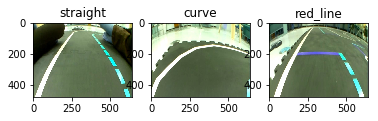

In [9]:
#10 straight , 300 curve , 410 red_line
show=[]
straight = cv2.imread('../dataset/original/10.jpg')
curve = cv2.imread('../dataset/original/300.jpg')
red_line = cv2.imread('../dataset/original/410.jpg')

fig, axes = plt.subplots(1, 3)
  
axes[0].set_title('straight')
axes[0].imshow(straight)
axes[1].set_title('curve')
axes[1].imshow(curve)
axes[2].set_title('red_line')
axes[2].imshow(red_line)

# Resize

In [14]:
image=straight
frame = cv2.resize(image,(100, 75))  

In [15]:
height=frame.shape[0]
width=frame.shape[1]

# Detect red line

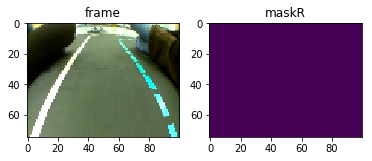

In [24]:
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
lowerR=np.array([220,70,70])
upperR=np.array([255,160,170])    
maskR = cv2.inRange(frame, lowerR, upperR)
countR = 0

for i in range(width):        
    if maskR[int(height/3)][i] == 255: 
        countR+=1
    if countR > 10:
        print('stop')
        break
        
fig, axes = plt.subplots(1, 2)  
axes[0].set_title('frame')
axes[0].imshow(frame)
axes[1].set_title('maskR')
axes[1].imshow(maskR)

# Gray image

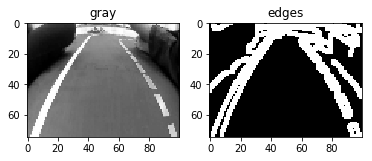

In [21]:
gray=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,100,200)
edges = dilation(edges, square(3))
# edges[:,width-3:width] = 0 
# edges = ndi.gaussian_filter(edges,2)

fig, axes = plt.subplots(1, 2)  
axes[0].set_title('gray')
axes[0].imshow(gray,cmap='gray')
axes[1].set_title('edges')
axes[1].imshow(edges,cmap='gray')

# Crop image

C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Bermuda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


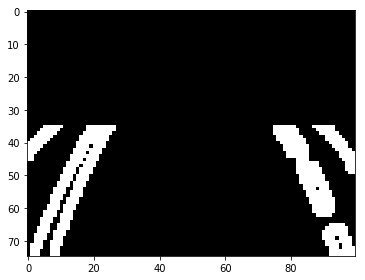

In [34]:
region_of_interest_vertices = [   
    (0, height),
    (0, (height/3)+10),
#     ((width/6), (height/3)+15),
#     (width-(width/6), (height/3)+15),
    (width, (height/3)+10),
    (width, height)]
crop = region_of_interest(edges,np.array([region_of_interest_vertices], np.int32))

imshow(crop)

# Hough Transform

In [37]:
lines = cv2.HoughLinesP(crop,rho = 1,theta = 1*np.pi/180,threshold = 40,minLineLength = 10,maxLineGap = 250)
font = cv2.FONT_HERSHEY_SIMPLEX
l=[]
r=[]
lines

array([[[75, 35, 99, 74]],

       [[ 7, 73, 25, 35]],

       [[ 1, 74, 21, 35]],

       [[ 1, 71, 19, 35]],

       [[ 7, 71, 24, 35]]], dtype=int32)

In [38]:
# Draw lines on the image
if(lines is not None) :
    for line in lines:  
        x1, y1, x2, y2 = line[0]
        if(findSlope((x1,y1),(x2,y2),width)):
            
            if(x1 < int(width/2)):
                l.append([x1,x2,y1,y2,findSlope((x1,y1),(x2,y2),width)])
                cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)
            else:
                r.append([x1,x2,y1,y2,findSlope((x1,y1),(x2,y2),width)])
                cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)

    l=np.array(l)
    r=np.array(r)
#     slope_leftP = slope_left
#     slope_rightP = slope_right
#     slope left
    if(len(l)):                
        slope_left = round(sum(l[:,4])/len(l),2)  
        x1 = round(sum(l[:,0])/len(l)).astype('int')
        x2 = round(sum(l[:,1])/len(l)).astype('int')
        y1 = round(sum(l[:,2])/len(l)).astype('int')
        y2 = round(sum(l[:,3])/len(l)).astype('int')
#         cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)
    else:
        slope_left = self.slope_leftP

    # slope right
    if(len(r)):                
        slope_right = round(sum(r[:,4])/len(r),2)
        x1 = round(sum(r[:,0])/len(r)).astype('int')
        x2 = round(sum(r[:,1])/len(r)).astype('int')
        y1 = round(sum(r[:,2])/len(r)).astype('int')
        y2 = round(sum(r[:,3])/len(r)).astype('int')
#         cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
    else:
        slope_right = self.slope_rightP


    slope = round(slope_right + slope_left,3)
    if(slope > 2):
        slope = 2
    elif(slope < -2):
        slope = -2  

    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
#     cv2.putText(frame,str(slope),(10,20), font, 0.5,(255,255,255),1,cv2.LINE_AA)


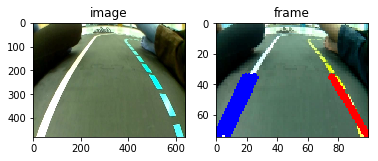

In [39]:
fig, axes = plt.subplots(1, 2)  
axes[0].set_title('image')
axes[0].imshow(image)
axes[1].set_title('frame')
axes[1].imshow(frame)